# Scaling Analysis

Author: Brain Gravelle (gravelle@cs.uoregon.edu)


All this is using the taucmdr python libraries from paratools
http://taucommander.paratools.com/



## Imports
This section imports necessary libraies, the metrics.py and utilities.py files and sets up the window.


<a id='top'></a>

In [73]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
import numbers
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2e' % x)
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth', 70)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import copy

<a href='#tot_cyc'>tot cyc</a><br>
<a href='#l1_mr'>l1_mr</a><br>
<a href='#l2_mr'>l2_mr</a><br>
<a href='#l3_mr'>l3_mr</a><br>
<a href='#branch_mr'>branch_mr</a><br>
<a href='#fetch_stall'>fetch_stall</a><br>
<a href='#vipi'>vipi</a><br>

## Getting Data

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

From the talapas_scaling application the following experiments are available. These use Talapas (with 28 thread Broadwell processors) and the build-ce (realistic) option for mkFit. The first six experiments use the --num-thr option to set the thread count which is intended to perform threading within the events. the last two add the --num-ev-thr option to set the event threads, so that all threads are used to process events in parallel and each event is processed by a single thread. 
* manual_scaling_Large_talapas		
* manual_scaling_Large_talapas_fullnode	
* manual_scaling_TTbar70_talapas		
* manual_scaling_TTbar70_talapas_fullnode
* manual_scaling_TTbar35_talapas
* manual_scaling_TTbar35_talapas_fullnode
* ev_thr_scaling_Large_talapas
* ev_thr_scaling_Large_talapas_fullnode

Additionally available in the cori_scaling application are the following. These were run on NERSC's Cori on the KNL with the default memory settings (quad - 1 NUMA domain, cache - MCDRAM as direct mapped cache). See http://www.nersc.gov/users/computational-systems/cori/running-jobs/advanced-running-jobs-options/ for more info on the KNL modes. Similar to the talapas scaling they use the build-ce option and threading within each event.
* manual_scaling_TTbar35
* manual_scaling_TTbar70
* manual_scaling_Large
* mixed_thr_scaling_Large - this is bad


### Importing Scaling Data - Cori TTbar70 is current
Here we import the data. In this case we are using Cori data from the experiments with the threads working within each event using the TTbar70 file. Note that this box will take an hour or more to run; please go enjoy a coffee while you wait.

In [2]:
# application = "talapas_scaling"
# experiment  = "manual_scaling_TTbar70_talapas"
# experiment  = "manual_scaling_Large_talapas"
# experiment = "ev_thr_scaling_Large_talapas"

application = "cori_scaling"
# experiment  = "manual_scaling_TTbar35"
experiment  = "manual_scaling_TTbar70"
# experiment  = "manual_scaling_Large"
# experiment  = "mixed_thr_scaling_Large"

path = ".tau/" + application + "/" + experiment + "/"
# note that this function takes a long time to run, so only rerun if you must

metric_data = get_pandas_scaling(path, callpaths=True)
    
if application == "talapas_scaling":
    metric_data = remove_erroneous_threads(metric_data,  [1, 8, 16, 32, 48, 56])
elif application == "cori_scaling":
    print(metric_data.keys())
    metric_data = remove_erroneous_threads(metric_data,  [1, 4, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256])

Parsing ERROR: 
dir = .tau/cori_scaling/manual_scaling_TTbar70/0_208_61//MULTI__PAPI_LST_INS
Found: 1101 trials with 10 errors


[256, 64, 1, 8, 128, 16, 18, 32, 112, 34, 176, 48, 192, 160, 96, 80, 82, 224, 144, 226, 208, 146, 272, 240]


In [3]:
# metric_data[8]['PAPI_TOT_CYC'].head(10)

## A list of metrics

In [4]:
print_available_metrics(metric_data,True)

for key in metric_data[metric_data.keys()[5]]:
    if not key == 'METADATA':
        print(key)
print(metric_data.keys())

PAPI_BR_INS
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD
PAPI_L2_TCA
PAPI_NATIVE_LLC_MISSES
PAPI_TLB_DM
PAPI_NATIVE_LLC_REFERENCES
PAPI_RES_STL
PAPI_L2_TCM
PAPI_TOT_INS
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD
PAPI_NATIVE_FETCH_STALL
PAPI_LST_INS
PAPI_BR_UCN
PAPI_NATIVE_RS_FULL_STALL
PAPI_BR_CN
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_TOT_CYC
PAPI_BR_INS
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD
PAPI_L2_TCA
PAPI_NATIVE_LLC_MISSES
PAPI_TLB_DM
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD
PAPI_RES_STL
PAPI_L2_TCM
PAPI_TOT_INS
PAPI_BR_UCN
PAPI_NATIVE_FETCH_STALL
PAPI_LST_INS
PAPI_BR_CN
PAPI_NATIVE_RS_FULL_STALL
PAPI_NATIVE_LLC_REFERENCES
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_TOT_CYC
[256, 64, 240, 32, 144, 1, 8, 112, 128, 176, 192, 224, 96, 16, 80, 48, 160, 208]


#### Metric metadata

In [5]:
# print_metadata(metric_data[8])

## Adding metrics

metrics are available in metrics.py. At this time the following can be added:
* add_IPC(metrics)          - Instructions per Cycle
* add_CPI(metrics)          - Cycles per instruction
* add_VIPC(metrics)         - vector instructions per cycle
* add_VIPI(metrics)         - vector instructions per instruction (i.e. fraction of total)
* add_L1_missrate(metrics)  - miss rate for L1 cache

for scaling data please use the add_metric_to_scaling_data(data, metric_func) function to add a metric

Here we add some predeefined metrics and print the top 10 functions with the best IPC

In [6]:
add_metric_to_scaling_data(metric_data, add_CPI)
add_metric_to_scaling_data(metric_data, add_IPC)
add_metric_to_scaling_data(metric_data, add_L1_missrate)
add_metric_to_scaling_data(metric_data, add_L2_missrate)
add_metric_to_scaling_data(metric_data, add_VIPI)
if application == 'cori_scaling': llc = True
else: llc = False
add_metric_to_scaling_data(metric_data, add_L3_missrate, llc)
print_available_metrics(metric_data, scaling=True)

# metric_data[1]['DERIVED_IPC'].sort_values(by='Inclusive',ascending=False).head(10)

DERIVED_VIPI
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD
PAPI_L2_TCA
PAPI_NATIVE_LLC_MISSES
PAPI_TLB_DM
PAPI_L2_TCM
PAPI_NATIVE_FETCH_STALL
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD
DERIVED_CPI
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_RES_STL
PAPI_TOT_INS
PAPI_BR_CN
DERIVED_L1_MISSRATE
DERIVED_L3_MISSRATE
PAPI_BR_UCN
PAPI_NATIVE_LLC_REFERENCES
PAPI_BR_INS
DERIVED_L2_MISSRATE
DERIVED_IPC
PAPI_LST_INS
PAPI_NATIVE_RS_FULL_STALL
PAPI_TOT_CYC


In [7]:
add_metric_to_scaling_data(metric_data, add_DERIVED_BRANCH_MR)
add_metric_to_scaling_data(metric_data, add_DERIVED_RATIO_FETCH_STL_TOT_CYC)


# metric_data[1]['DERIVED_BRANCH_MR'].sort_values(by='Inclusive',ascending=False).head(10)

## Scaling Results

In this section we demo some scaling results with several different metrics.

We use the scaling plot function to plot the data vs thread count.
scaling_plot(data, inclusive=True, plot=True, function="\[SUMMARY\] .TAU application$", metric='PAPI_TOT_CYC', max=False)
* data = the full dictionary of scaling data 
* inclusive = determines if the inclusive data or exclusive data will be used
* plot = true makes a plot false does not
* function = the string that will be searched for to plot. Default looks at the whole application
* metric = the metric choosen from the above list
* max = use the max value or average value across the threads

## Scaling with total cycles vs the thread count
Here we plot the cycle count for each thread count as a proxy for execution time. We use the max cycle count rather than the average as this number will limit the time of execution.

<a id='tot_cyc'></a>

<a href='#top'>top</a><br>
<a href='#tot_cyc'>tot cyc</a><br>
<a href='#l1_mr'>l1_mr</a><br>
<a href='#l2_mr'>l2_mr</a><br>
<a href='#l3_mr'>l3_mr</a><br>
<a href='#branch_mr'>branch_mr</a><br>
<a href='#fetch_stall'>fetch_stall</a><br>
<a href='#vipi'>vipi</a><br>

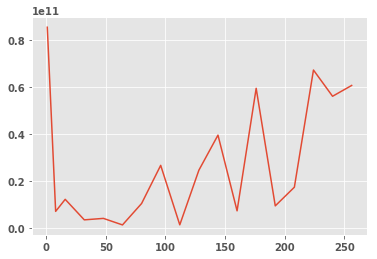

In [8]:
thread_list, tot_cyc_list = scaling_plot(metric_data, function="\[SUMMARY\] .TAU application$", max=True)

In [9]:
THREAD_COUNT = 1
# func = 'clean_cms_seedtracks'
func = 'NULL'
cyc_data = select_metric_from_scaling(metric_data, 'PAPI_TOT_CYC')
# get_func_level_metric(cyc_data[THREAD_COUNT], avg=True, func="LayerOfHits::").head(20)
get_func_level_metric(cyc_data[THREAD_COUNT], avg=True, func=func).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.05e+10
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.05e+10
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,5.73e+09
[SUMMARY] __svml_sincosf8_l9,5.73e+09
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",4.86e+09
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",4.86e+09
[SUMMARY] Event::clean_cms_seedtracks(),4.67e+09
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Event::clean_cms_seedtracks(),4.67e+09
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",3.28e+09


In [10]:
THREAD_COUNT = 8
func = 'NULL'
# func = 'helixAtRFromIterativeCCS'
# func = 'MultHelixPropTransp'
# func = '.TAU application$'
cyc_data = select_metric_from_scaling(metric_data, 'PAPI_TOT_CYC')
get_func_level_metric(cyc_data[THREAD_COUNT], avg=True, func=func).head(20)


# bottom of top ten = 2.1e8
# total is 4.4e9

,Exclusive
region,
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Event::clean_cms_seedtracks(),1.17e+09
[SUMMARY] Event::clean_cms_seedtracks(),1.17e+09
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] syscall,5.44e+08
[SUMMARY] syscall,5.44e+08
"[SUMMARY] std::__detail::_Mod_range_hashing::operator()(unsigned long, unsigned long) const",5.31e+08
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] std::__detail::_Mod_range_hashing::operator()(unsigned long, unsigned long) const",5.31e+08
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",5.21e+08
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",5.21e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] _int_free,3.42e+08


In [11]:
THREAD_COUNT = 48
# func = 'FindCandidatesCloneEngine'
func = 'NULL'
cyc_data = select_metric_from_scaling(metric_data, 'PAPI_TOT_CYC')
get_func_level_metric(cyc_data[THREAD_COUNT], avg=True, func = func).head(30)


,Exclusive
region,
[SUMMARY] __lll_lock_wait_private,1.03e+09
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __lll_lock_wait_private,1.03e+09
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] syscall,4.55e+08
[SUMMARY] syscall,4.55e+08
[SUMMARY] Event::clean_cms_seedtracks(),3.45e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Event::clean_cms_seedtracks(),3.45e+08
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] std::__detail::_Mod_range_hashing::operator()(unsigned long, unsigned long) const",1.31e+08
"[SUMMARY] std::__detail::_Mod_range_hashing::operator()(unsigned long, unsigned long) const",1.31e+08
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.03e+08


### Cycles per thread for each thread count
Here we show load balancing with a series of plots showing the cycle count per thread. We have one plot for each thread count used

1


<BarContainer object of 1 artists>

(0.0, 50000000000)

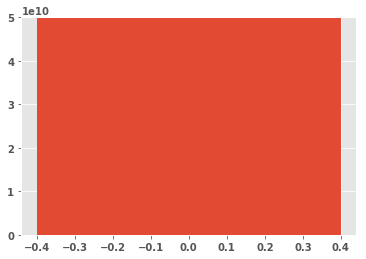

8


<BarContainer object of 8 artists>

(0.0, 50000000000)

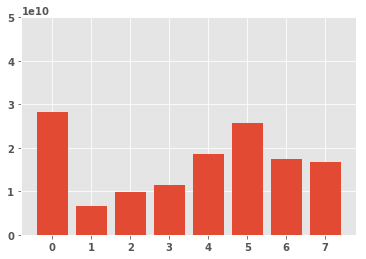

16


<BarContainer object of 16 artists>

(0.0, 50000000000)

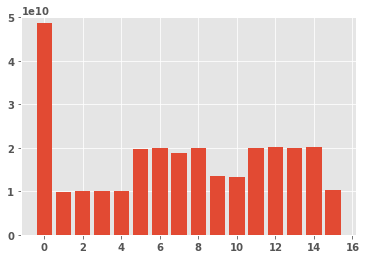

32


<BarContainer object of 32 artists>

(0.0, 50000000000)

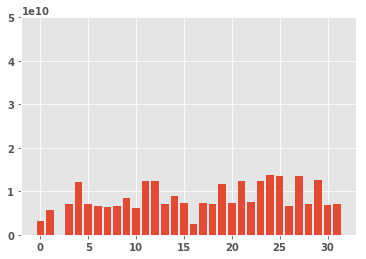

48


<BarContainer object of 48 artists>

(0.0, 50000000000)

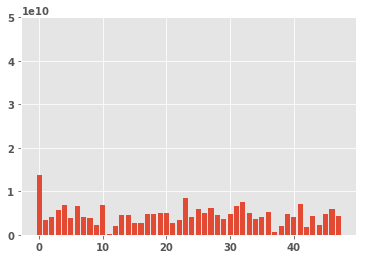

64


<BarContainer object of 64 artists>

(0.0, 50000000000)

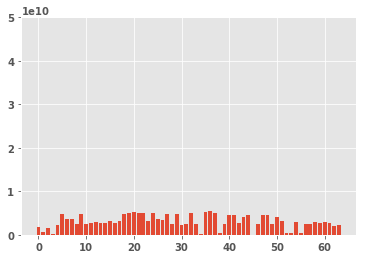

80


<BarContainer object of 80 artists>

(0.0, 50000000000)

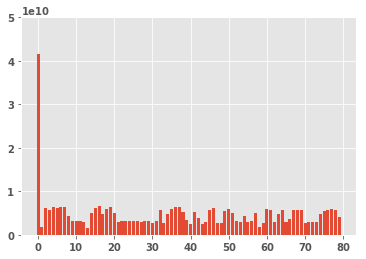

96


<BarContainer object of 96 artists>

(0.0, 50000000000)

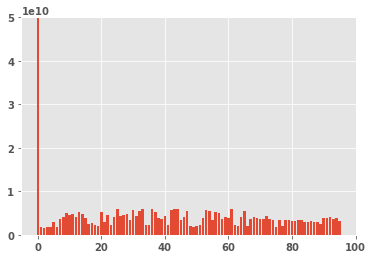

112


<BarContainer object of 112 artists>

(0.0, 50000000000)

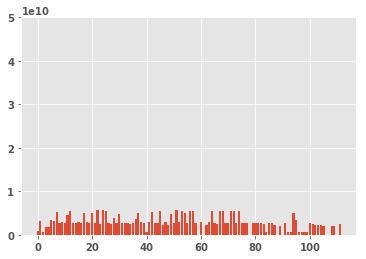

128


<BarContainer object of 128 artists>

(0.0, 50000000000)

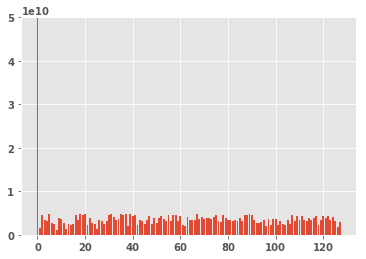

144


<BarContainer object of 144 artists>

(0.0, 50000000000)

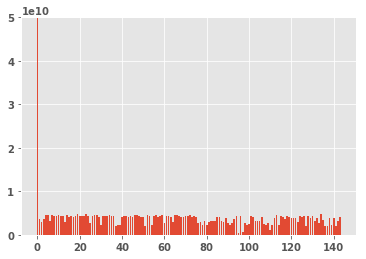

160


<BarContainer object of 160 artists>

(0.0, 50000000000)

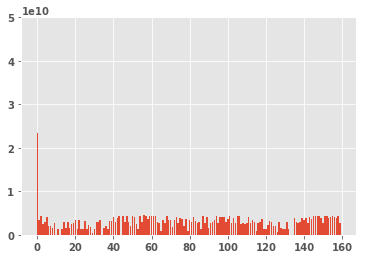

176


<BarContainer object of 176 artists>

(0.0, 50000000000)

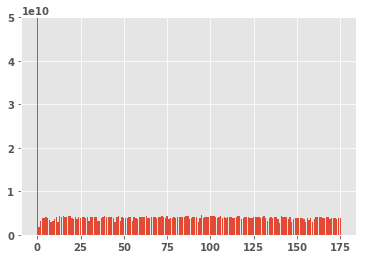

192


<BarContainer object of 192 artists>

(0.0, 50000000000)

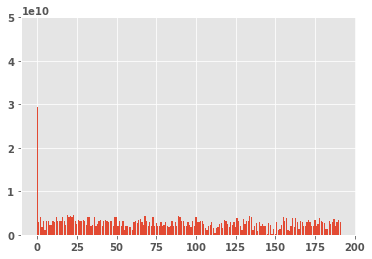

208


<BarContainer object of 208 artists>

(0.0, 50000000000)

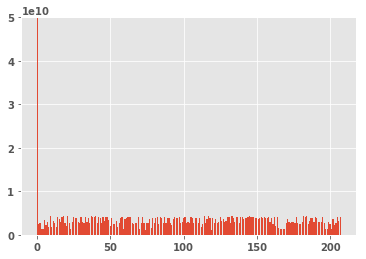

224


<BarContainer object of 224 artists>

(0.0, 50000000000)

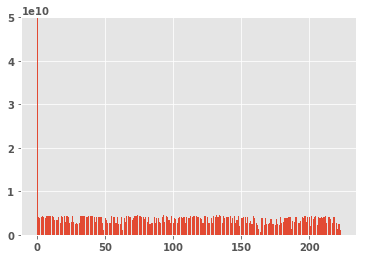

240


<BarContainer object of 240 artists>

(0.0, 50000000000)

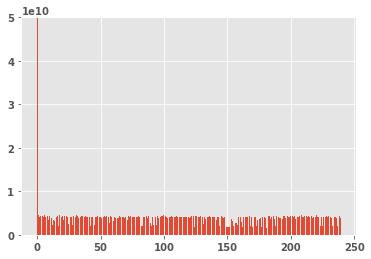

256


<BarContainer object of 256 artists>

(0.0, 50000000000)

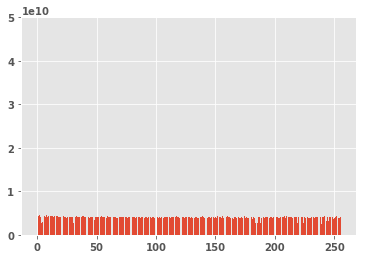

In [12]:
thread_cyc_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_TOT_CYC')

for kt in thread_list:
    print kt
    data = list(thread_cyc_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=50000000000) 
    matplotlib.pyplot.show()

## L1 Missrate vs thread count
Similar to above these cells show the L1 missrates. In this case we want to get the plotting data for L1 acceses and misses but comupte the miss rate before plotting, so we set plot=False

<a href='#top'>top</a><br>
<a href='#tot_cyc'>tot cyc</a><br>
<a href='#l1_mr'>l1_mr</a><br>
<a href='#l2_mr'>l2_mr</a><br>
<a href='#l3_mr'>l3_mr</a><br>
<a href='#branch_mr'>branch_mr</a><br>
<a href='#fetch_stall'>fetch_stall</a><br>
<a href='#vipi'>vipi</a><br>

<a id='l1_mr'></a>

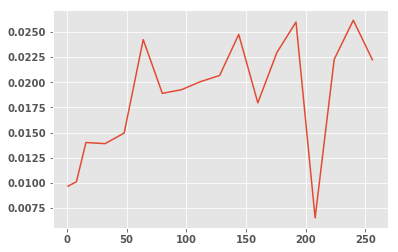

In [13]:
thread_list, L1A_data = scaling_plot(metric_data, plot=False, metric='PAPI_LST_INS')
thread_list, L1M_data = scaling_plot(metric_data, plot=False, metric='PAPI_L1_TCM')
    
L1_MR_list = [L1M_data[i] / L1A_data[i] for i in range(len(thread_list))]

plt = matplotlib.pyplot.plot(thread_list, L1_MR_list)

### L1 Miss rate by each thread of each thread count

1


<BarContainer object of 1 artists>

(0.0, 0.05)

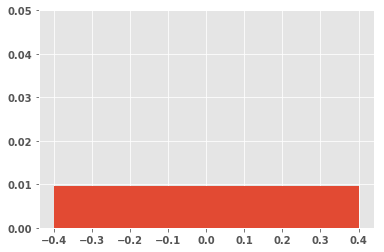

8


<BarContainer object of 8 artists>

(0.0, 0.05)

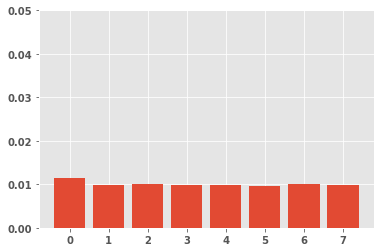

16


<BarContainer object of 16 artists>

(0.0, 0.05)

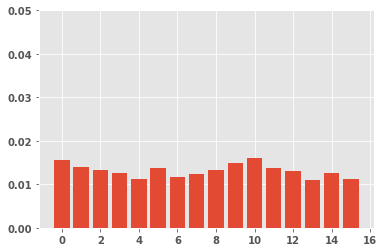

32


<BarContainer object of 32 artists>

(0.0, 0.05)

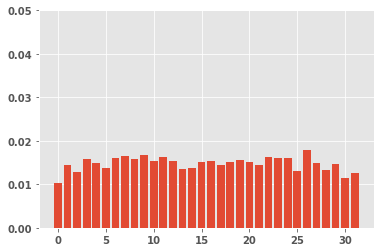

48


<BarContainer object of 48 artists>

(0.0, 0.05)

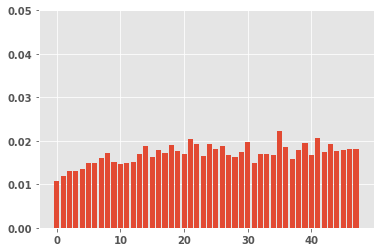

64


<BarContainer object of 64 artists>

(0.0, 0.05)

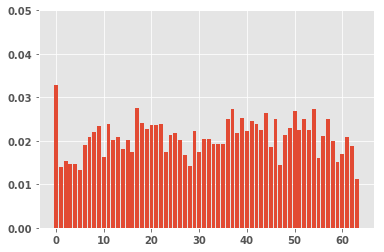

80


<BarContainer object of 80 artists>

(0.0, 0.05)

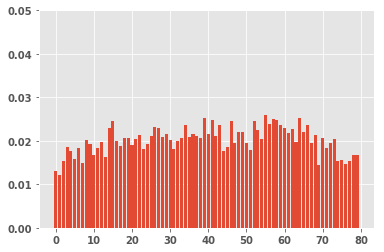

96


<BarContainer object of 96 artists>

(0.0, 0.05)

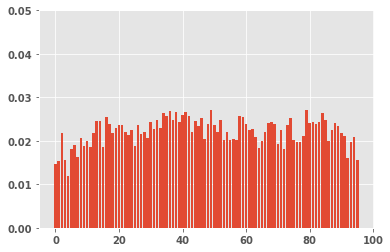

112


<BarContainer object of 112 artists>

(0.0, 0.05)

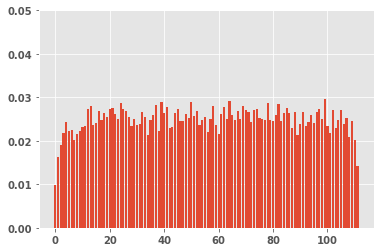

128


<BarContainer object of 128 artists>

(0.0, 0.05)

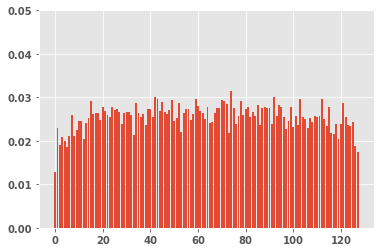

144


<BarContainer object of 144 artists>

(0.0, 0.05)

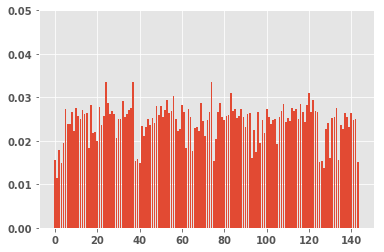

160


<BarContainer object of 160 artists>

(0.0, 0.05)

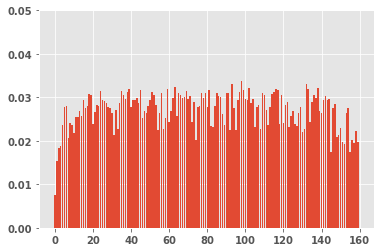

176


<BarContainer object of 176 artists>

(0.0, 0.05)

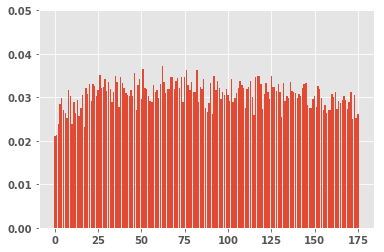

192


<BarContainer object of 192 artists>

(0.0, 0.05)

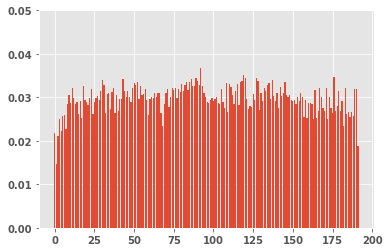

208


<BarContainer object of 208 artists>

(0.0, 0.05)

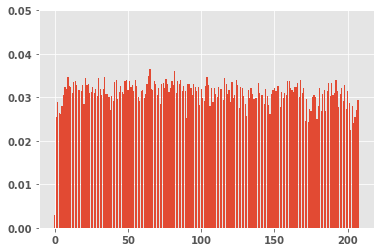

224


<BarContainer object of 224 artists>

(0.0, 0.05)

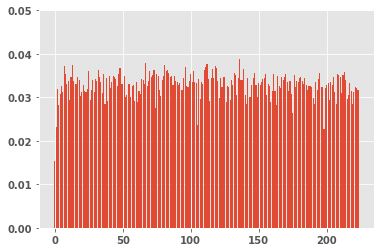

240


<BarContainer object of 240 artists>

(0.0, 0.05)

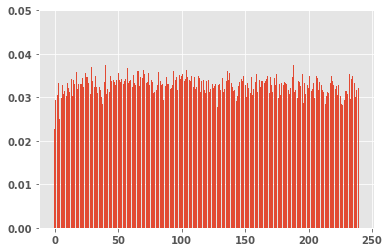

256


<BarContainer object of 256 artists>

(0.0, 0.05)

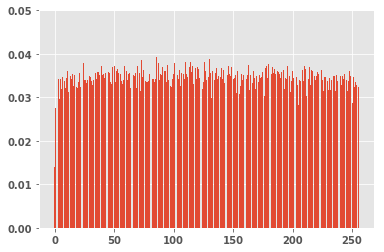

In [14]:
thread_L1A_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_LST_INS')
thread_L1M_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L1_TCM')

MR_data = {}
for kt in thread_list:
#     print(thread_L1M_data[kt])
#     print(thread_L1A_data[kt])
    MR_data[kt] = thread_L1M_data[kt] / thread_L1A_data[kt]
    
for kt in thread_list:
    print kt
    data = list(MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.05)
    matplotlib.pyplot.show()

### L1 Top 10 bad miss rates

In [15]:
L1_data = select_metric_from_scaling(metric_data, 'DERIVED_L1_MISSRATE')
L1_MR_dict = {}
for n_thr in thread_list:
    L1_MR_dict[n_thr] = filter_libs_out(L1_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [1]:
THREAD_COUNT = 1
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L1_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

NameError: name 'get_func_level_metric' is not defined

In [17]:
THREAD_COUNT = 8

get_func_level_metric(L1_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",9.77e-03
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",9.77e-03


In [18]:
THREAD_COUNT = 48
get_func_level_metric(L1_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.66e-02
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.66e-02


### L1 Top 10 bad miss counts

In [19]:
L1_tcm = select_metric_from_scaling(metric_data, 'PAPI_L1_TCM')
L1_tcm_dict = {}
for n_thr in thread_list:
    L1_tcm_dict[n_thr] = filter_libs_out(L1_tcm[n_thr])
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [20]:
THREAD_COUNT = 1
# func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L1_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",3.85e+07
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",3.85e+07


In [21]:
THREAD_COUNT = 8
get_func_level_metric(L1_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",4.73e+06
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",4.73e+06


In [22]:
THREAD_COUNT = 48
get_func_level_metric(L1_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",8.48e+05
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",8.48e+05


<a id='l2_mr'></a>


## L2 Missrate vs thread count
Similar to above these cells show the L2 missrates.

<a href='#top'>top</a><br>
<a href='#tot_cyc'>tot cyc</a><br>
<a href='#l1_mr'>l1_mr</a><br>
<a href='#l2_mr'>l2_mr</a><br>
<a href='#l3_mr'>l3_mr</a><br>
<a href='#branch_mr'>branch_mr</a><br>
<a href='#fetch_stall'>fetch_stall</a><br>
<a href='#vipi'>vipi</a><br>

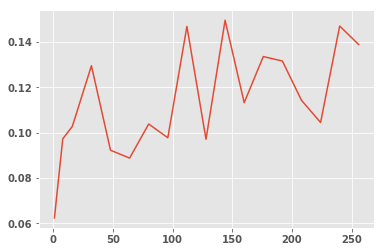

In [23]:
thread_list, L2A_data = scaling_plot(metric_data, plot=False, metric='PAPI_L2_TCA')
thread_list, L2M_data = scaling_plot(metric_data, plot=False, metric='PAPI_L2_TCM')
    
L2_MR_list = [L2M_data[i] / L2A_data[i] for i in range(len(thread_list))]

plt = matplotlib.pyplot.plot(thread_list, L2_MR_list)

1


<BarContainer object of 1 artists>

(0.0, 0.3)

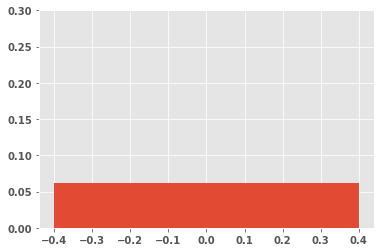

8


<BarContainer object of 8 artists>

(0.0, 0.3)

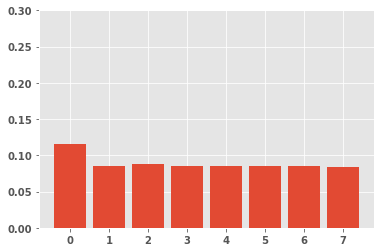

16


<BarContainer object of 16 artists>

(0.0, 0.3)

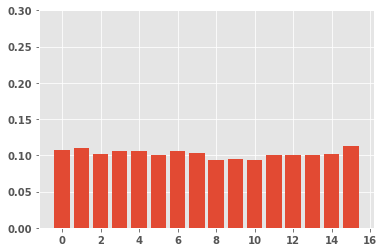

32


<BarContainer object of 32 artists>

(0.0, 0.3)

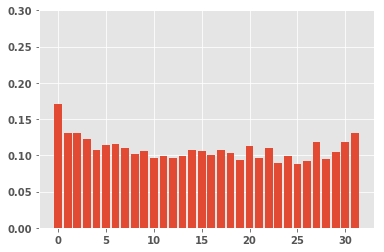

48


<BarContainer object of 48 artists>

(0.0, 0.3)

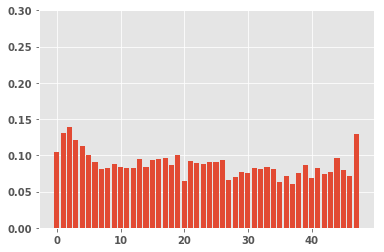

64


<BarContainer object of 64 artists>

(0.0, 0.3)

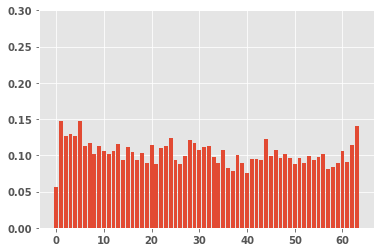

80


<BarContainer object of 80 artists>

(0.0, 0.3)

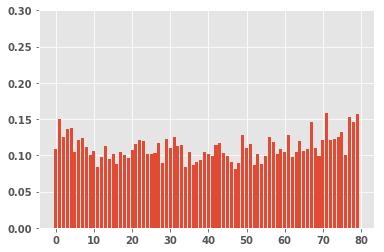

96


<BarContainer object of 96 artists>

(0.0, 0.3)

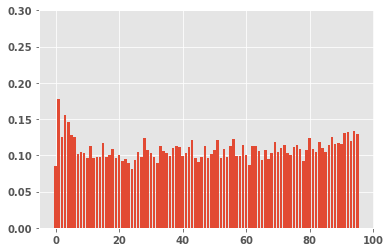

112


<BarContainer object of 112 artists>

(0.0, 0.3)

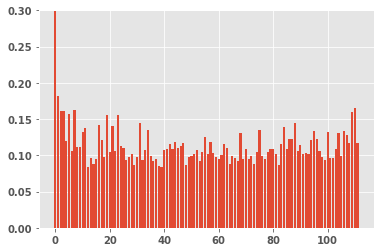

128


<BarContainer object of 128 artists>

(0.0, 0.3)

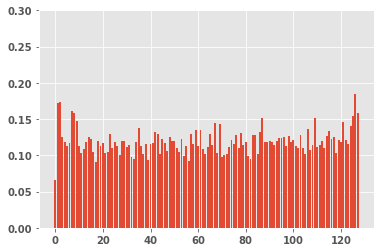

144


<BarContainer object of 144 artists>

(0.0, 0.3)

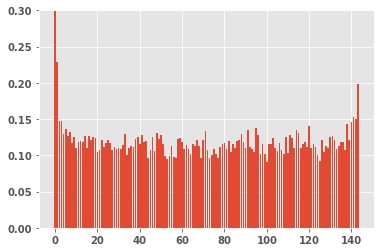

160


<BarContainer object of 160 artists>

(0.0, 0.3)

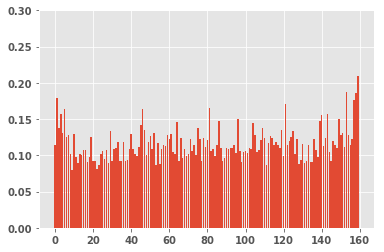

176


<BarContainer object of 176 artists>

(0.0, 0.3)

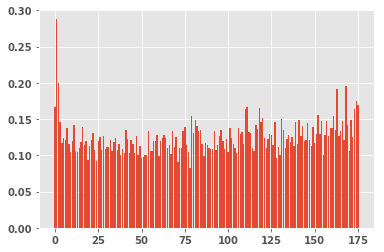

192


<BarContainer object of 192 artists>

(0.0, 0.3)

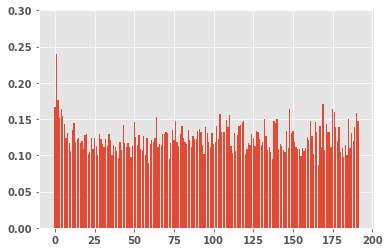

208


<BarContainer object of 208 artists>

(0.0, 0.3)

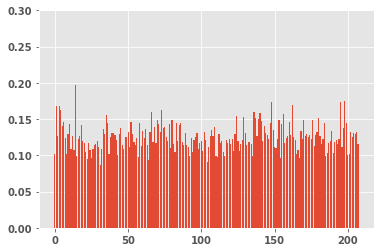

224


<BarContainer object of 224 artists>

(0.0, 0.3)

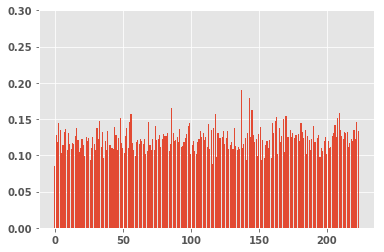

240


<BarContainer object of 240 artists>

(0.0, 0.3)

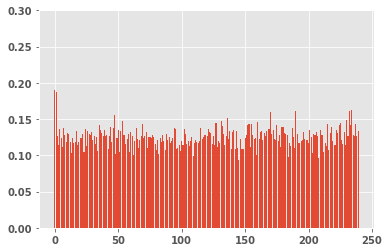

256


<BarContainer object of 256 artists>

(0.0, 0.3)

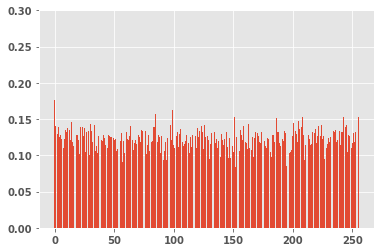

In [24]:
thread_L2A_data = get_thread_level_metric_scaling(select_metric_from_scaling(metric_data, 'PAPI_L2_TCA'))
thread_L2M_data = get_thread_level_metric_scaling(select_metric_from_scaling(metric_data, 'PAPI_L2_TCM'))


L2_MR_data = {}
for kt in thread_list:
    L2_MR_data[kt] = thread_L2M_data[kt] / thread_L2A_data[kt]
    
for kt in thread_list:
    print kt
    data = list(L2_MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.3)
    matplotlib.pyplot.show()

### L2 Top 10 bad miss rates

In [25]:
L2_data = select_metric_from_scaling(metric_data, 'DERIVED_L2_MISSRATE')
L2_MR_dict = {}
for n_thr in thread_list:
    L2_MR_dict[n_thr] = filter_libs_out(L2_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [26]:
THREAD_COUNT = 8
# func = 'NULL'
func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L1_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",9.88e-03
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",9.88e-03


In [27]:
THREAD_COUNT = 8
get_func_level_metric(L2_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",9.08e-02
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",9.08e-02


In [28]:
THREAD_COUNT = 8
get_func_level_metric(L3_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

NameError: name 'L3_MR_dict' is not defined

### ALL CACHE Top 10 bad miss counts

In [29]:
L2_tcm = select_metric_from_scaling(metric_data, 'PAPI_L2_TCM')
L2_tcm_dict = {}
for n_thr in thread_list:
    L2_tcm_dict[n_thr] = filter_libs_out(L2_tcm[n_thr])
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [30]:
THREAD_COUNT = 8
# func = 'NULL'
func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L1_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",2.24e+06
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",2.24e+06


In [31]:
THREAD_COUNT = 8
get_func_level_metric(L2_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",4.98e+05
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",4.98e+05


In [32]:
THREAD_COUNT = 8
get_func_level_metric(L3_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

NameError: name 'L3_tcm_dict' is not defined

#### Total Cache misses

In [ ]:
THREAD_COUNT = 8
get_func_level_metric(L1_tcm_dict[THREAD_COUNT], func='.TAU application$', inclusive='inclusive', avg=True).head(20)

In [33]:
THREAD_COUNT = 8
get_func_level_metric(L2_tcm_dict[THREAD_COUNT], func='.TAU application$', inclusive='inclusive', avg=True).head(20)

,Inclusive
region,
[SUMMARY] .TAU application => [CONTEXT] .TAU application,1.04e+07
[SUMMARY] .TAU application,1.04e+07


In [34]:
THREAD_COUNT = 8
get_func_level_metric(L3_tcm_dict[THREAD_COUNT], func='.TAU application$', inclusive='inclusive', avg=True).head(20)

NameError: name 'L3_tcm_dict' is not defined

## L3 Missrate vs thread count
Similar to above these cells show the L3 missrates.


<a href='#top'>top</a><br>
<a id='l3_mr'></a>

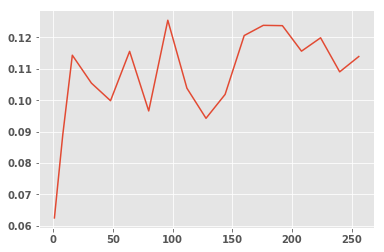

In [35]:
if application == 'talapas_scaling':
    thread_list, LLA_data = scaling_plot(metric_data, plot=False, metric='PAPI_L3_TCA')
    thread_list, LLM_data = scaling_plot(metric_data, plot=False, metric='PAPI_L3_TCM')
else:
    thread_list, LLA_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_LLC_REFERENCES')
    thread_list, LLM_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_LLC_MISSES')
    
LL_MR_list = [LLM_data[i] / LLA_data[i] for i in range(len(thread_list))]

plt = matplotlib.pyplot.plot(thread_list, LL_MR_list)

Thread Count: 1


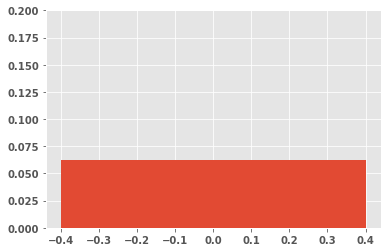

Thread Count: 8


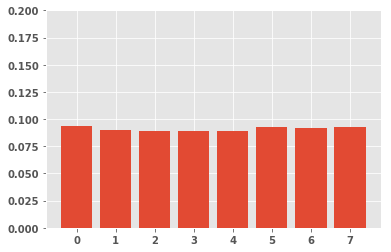

Thread Count: 16


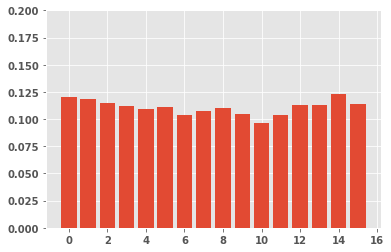

Thread Count: 32


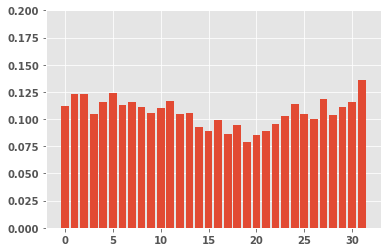

Thread Count: 48


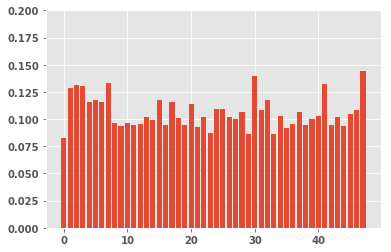

Thread Count: 64


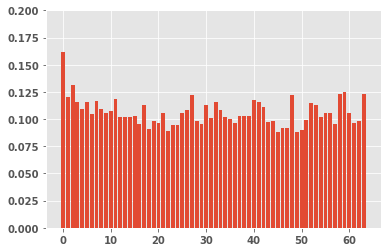

Thread Count: 80


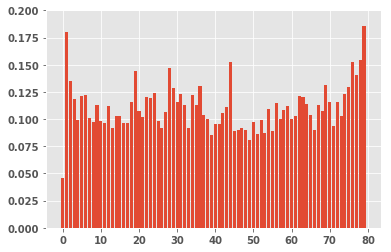

Thread Count: 96


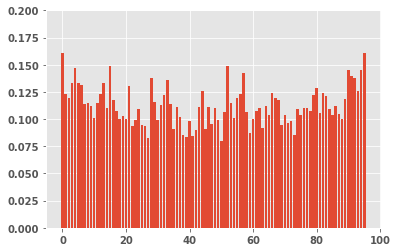

Thread Count: 112


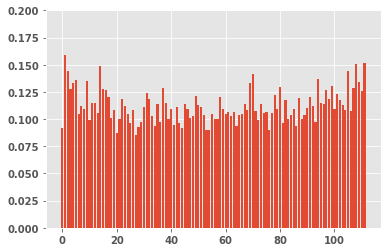

Thread Count: 128


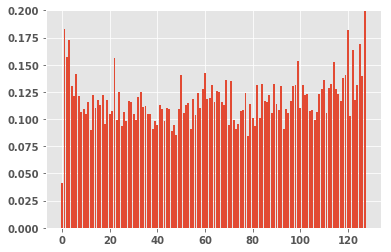

Thread Count: 144


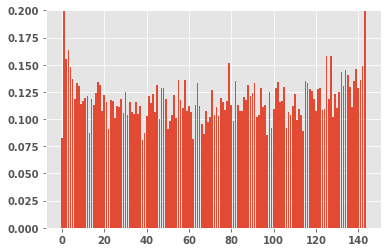

Thread Count: 160


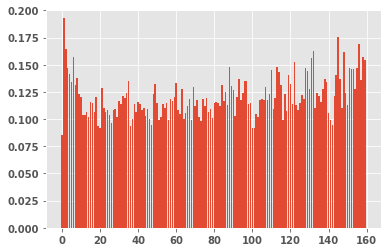

Thread Count: 176


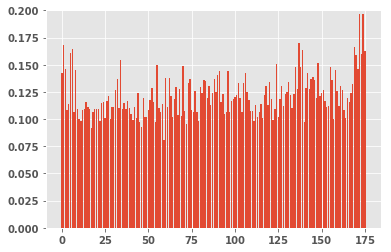

Thread Count: 192


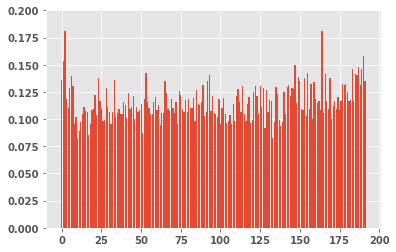

Thread Count: 208


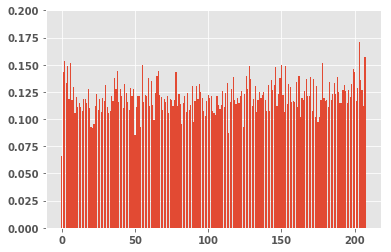

Thread Count: 224


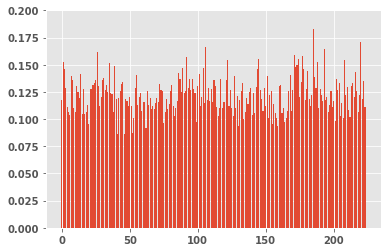

Thread Count: 240


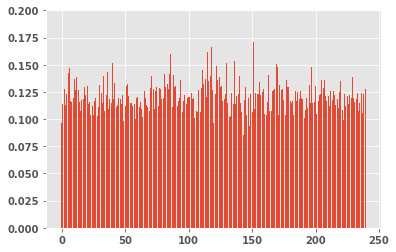

Thread Count: 256


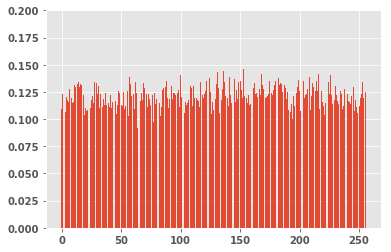

In [36]:
if application == 'talapas_scaling':
    thread_LLA_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L3_TCA')
    thread_LLM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L3_TCM')
else:
    thread_LLA_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_LLC_REFERENCES')
    thread_LLM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_LLC_MISSES')


LL_MR_data = {}
for kt in thread_list:
    LL_MR_data[kt] = thread_LLM_data[kt] / thread_LLA_data[kt]

def thread_bar_plots(data_dict, t_list, y=-1):
    for kt in t_list:
        print "Thread Count: %d" % kt
        data = list(data_dict[kt])
        matplotlib.pyplot.bar(range(len(data)), data)
        if y != -1:
            matplotlib.pyplot.ylim(ymax=y)
        matplotlib.pyplot.show()

thread_bar_plots(LL_MR_data, thread_list, 0.2)


### L3 Top 10 bad miss rates

In [37]:
L3_data = select_metric_from_scaling(metric_data, 'DERIVED_L3_MISSRATE')
L3_MR_dict = {}
for n_thr in thread_list:
    L3_MR_dict[n_thr] = filter_libs_out(L3_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [38]:
THREAD_COUNT = 1
# func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L3_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",5.38e-02
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",5.38e-02


In [39]:
THREAD_COUNT = 8
get_func_level_metric(L3_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",9.28e-02
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",9.28e-02


In [40]:
THREAD_COUNT = 48
get_func_level_metric(L3_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",9.11e-02
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",9.11e-02


### L3 Top 10 bad miss counts

In [41]:
L3_tcm = select_metric_from_scaling(metric_data, 'PAPI_NATIVE_LLC_MISSES')
L3_tcm_dict = {}
for n_thr in thread_list:
    L3_tcm_dict[n_thr] = filter_libs_out(L1_tcm[n_thr])
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [42]:
THREAD_COUNT = 1
# func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L3_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",3.85e+07
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",3.85e+07


In [43]:
THREAD_COUNT = 8
get_func_level_metric(L3_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",4.73e+06
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",4.73e+06


In [44]:
THREAD_COUNT = 48
get_func_level_metric(L3_tcm_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",8.48e+05
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",8.48e+05


## Branch Missrate vs thread count
Similar to above these cells show the rate of misspredicted branches.


<a href='#top'>top</a><br>
<a id='branch_mr'></a>

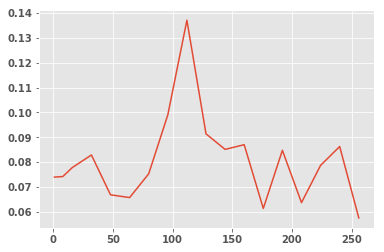

In [45]:
thread_list, BR_INS_data = scaling_plot(metric_data, plot=False, metric='PAPI_BR_INS')
thread_list, BR_MSP_data = scaling_plot(metric_data, plot=False, metric='PAPI_BR_MSP')
    
BR_MR_list = [BR_MSP_data[i] / BR_INS_data[i] for i in range(len(thread_list))]

plt = matplotlib.pyplot.plot(thread_list, BR_MR_list)

### Branch Miss rate by each thread of each thread count

1


<BarContainer object of 1 artists>

(0.0, 0.2)

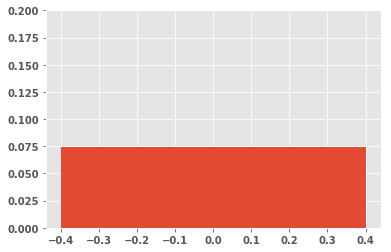

8


<BarContainer object of 8 artists>

(0.0, 0.2)

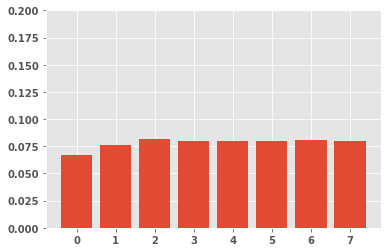

16


<BarContainer object of 16 artists>

(0.0, 0.2)

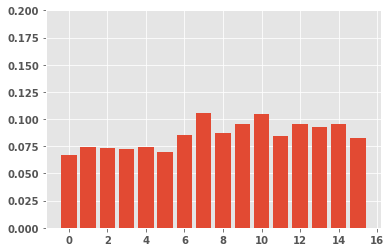

32


<BarContainer object of 32 artists>

(0.0, 0.2)

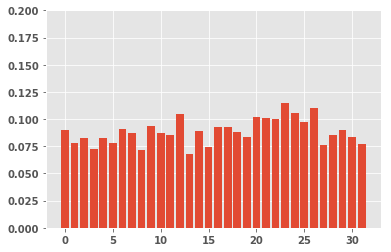

48


<BarContainer object of 48 artists>

(0.0, 0.2)

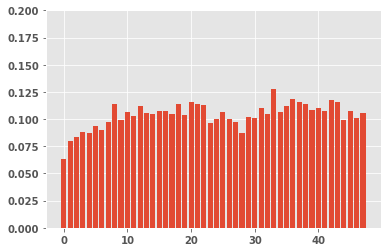

64


<BarContainer object of 64 artists>

(0.0, 0.2)

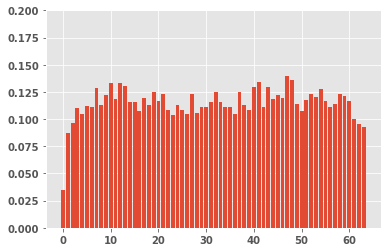

80


<BarContainer object of 80 artists>

(0.0, 0.2)

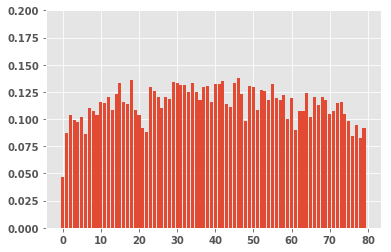

96


<BarContainer object of 96 artists>

(0.0, 0.2)

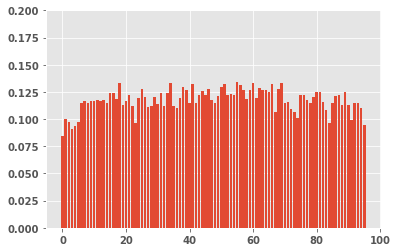

112


<BarContainer object of 112 artists>

(0.0, 0.2)

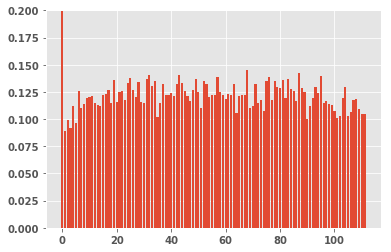

128


<BarContainer object of 128 artists>

(0.0, 0.2)

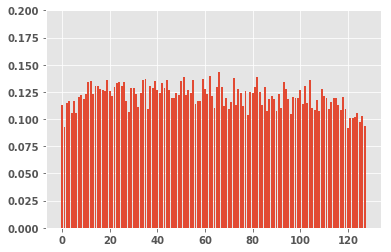

144


<BarContainer object of 144 artists>

(0.0, 0.2)

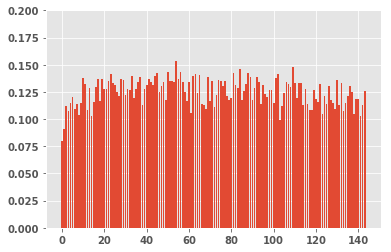

160


<BarContainer object of 160 artists>

(0.0, 0.2)

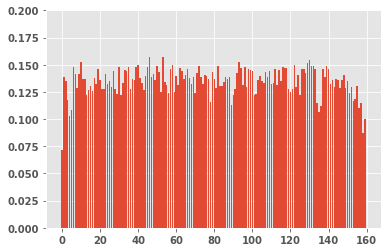

176


<BarContainer object of 176 artists>

(0.0, 0.2)

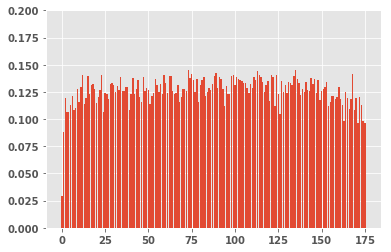

192


<BarContainer object of 192 artists>

(0.0, 0.2)

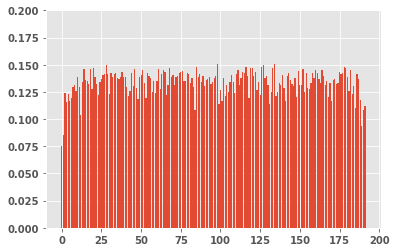

208


<BarContainer object of 208 artists>

(0.0, 0.2)

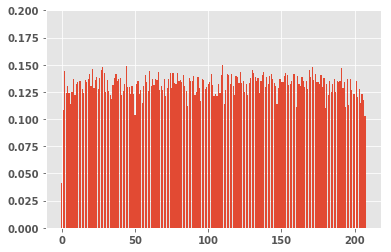

224


<BarContainer object of 224 artists>

(0.0, 0.2)

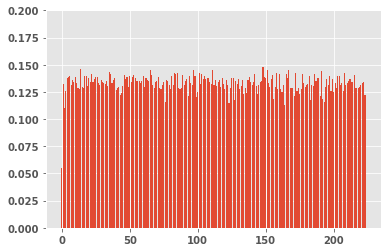

240


<BarContainer object of 240 artists>

(0.0, 0.2)

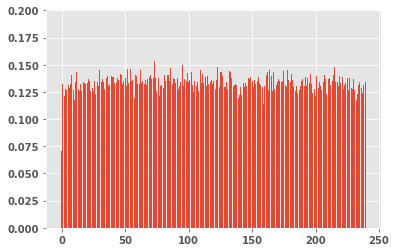

256


<BarContainer object of 256 artists>

(0.0, 0.2)

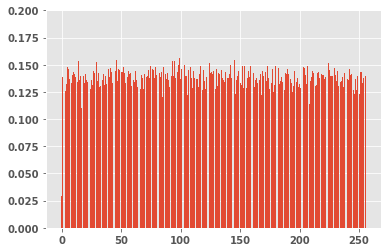

In [46]:
thread_BR_INS_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_BR_INS')
thread_BR_MSP_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_BR_MSP')

MR_data = {}
for kt in thread_list:
#     print(thread_L1M_data[kt])
#     print(thread_L1A_data[kt])
    MR_data[kt] = thread_BR_MSP_data[kt] / thread_BR_INS_data[kt]
    
for kt in thread_list:
    print kt
    data = list(MR_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.2)
    matplotlib.pyplot.show()

### Branch Top 10 bad miss rates

In [47]:
BR_data = select_metric_from_scaling(metric_data, 'DERIVED_BRANCH_MR')
BR_MR_dict = {}
for n_thr in thread_list:
    BR_MR_dict[n_thr] = filter_libs_out(BR_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [48]:
THREAD_COUNT = 1
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(BR_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] LayerInfo::is_within_z_sensitive_region(float, float) const",1.94e-01
"[SUMMARY] LayerInfo::is_within_z_sensitive_region(float, float) const",1.94e-01
"[SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::operator()(int, int, int) const",1.46e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 6, 1, 8>::operator()(int, int, int) const",1.46e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<int, 1, 1, 8>::operator()(int, int, int) const",1.41e-01
"[SUMMARY] Matriplex::Matriplex<int, 1, 1, 8>::operator()(int, int, int) const",1.41e-01
"[SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::ConstAt(int, int, int) const",1.40e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 6, 1, 8>::ConstAt(int, int, int) const",1.40e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] computeChi2MPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::MatriplexSym<float, 3, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::Matriplex<float, 1, 1, 8>&, int)",1.35e-01


In [49]:
THREAD_COUNT = 8
func = 'NULL'
get_func_level_metric(BR_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] Track::addHitIdx(int, int, float)",2.30e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Track::addHitIdx(int, int, float)",2.30e-01
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Track::errors_nc(),1.94e-01
[SUMMARY] Track::errors_nc(),1.94e-01
"[SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::CopyIn(int, float const*)",1.69e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::MatriplexSym<float, 3, 8>::CopyIn(int, float const*)",1.69e-01
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_atan2f8_l9,1.46e-01
[SUMMARY] __svml_atan2f8_l9,1.46e-01
"[SUMMARY] (anonymous namespace)::SubtractFirst2(Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<float, 2, 1, 8>&)",1.43e-01


In [50]:
THREAD_COUNT = 48
get_func_level_metric(BR_MR_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] LayerOfHits::alloc_hits(int),1.08e+00
[SUMMARY] LayerOfHits::alloc_hits(int),1.08e+00
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, float, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)",5.43e-01
"[SUMMARY] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, float, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)",5.43e-01
"[SUMMARY] propagateHelixToRMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int, bool)",5.19e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] propagateHelixToRMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int, bool)",5.19e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] ROOT::Math::MatRepSym<float, 6u>::operator=(ROOT::Math::MatRepSym<float, 6u> const&)",3.33e-01
"[SUMMARY] ROOT::Math::MatRepSym<float, 6u>::operator=(ROOT::Math::MatRepSym<float, 6u> const&)",3.33e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Track::addHitIdx(int, int, float)",3.22e-01


### Branch Top 10 bad miss counts

In [51]:
BR_msp = select_metric_from_scaling(metric_data, 'PAPI_BR_INS')
# BR_msp = select_metric_from_scaling(metric_data, 'PAPI_BR_MSP')
BR_msp_dict = {}
for n_thr in thread_list:
    BR_msp_dict[n_thr] = filter_libs_out(BR_msp[n_thr])
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [52]:
THREAD_COUNT = 1
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(BR_msp_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",8.85e+08
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",8.85e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Event::clean_cms_seedtracks(),6.44e+08
[SUMMARY] Event::clean_cms_seedtracks(),6.44e+08
[SUMMARY] __svml_sincosf8_l9,4.88e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,4.88e+08
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",4.05e+08
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",4.05e+08
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",2.98e+08


In [53]:
THREAD_COUNT = 8
get_func_level_metric(BR_msp_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Event::clean_cms_seedtracks(),6.35e+08
[SUMMARY] Event::clean_cms_seedtracks(),6.35e+08
[SUMMARY] _int_free,1.70e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] _int_free,1.70e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] _int_malloc,1.53e+08
[SUMMARY] _int_malloc,1.53e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] malloc_consolidate,1.44e+08
[SUMMARY] malloc_consolidate,1.44e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __GI___libc_malloc,1.16e+08


In [54]:
THREAD_COUNT = 48
func = 'NULL'
# func = 'MultHelixPropTransp'
get_func_level_metric(BR_msp_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
[SUMMARY] Event::clean_cms_seedtracks(),6.18e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Event::clean_cms_seedtracks(),6.18e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] _int_free,1.82e+08
[SUMMARY] _int_free,1.82e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] malloc_consolidate,1.44e+08
[SUMMARY] malloc_consolidate,1.44e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] _int_malloc,1.35e+08
[SUMMARY] _int_malloc,1.35e+08
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __GI___libc_malloc,1.31e+08


## Fetch Stall Top 10
Includes fetch stalls per tot cyc
and raw counts


<a href='#top'>top</a><br>
<a id='fetch_stall'></a>

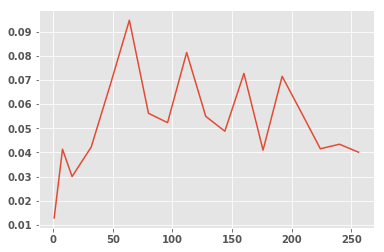

In [55]:
thread_list, FETCH_STALL_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_FETCH_STALL')
thread_list, TOT_CYC_data = scaling_plot(metric_data, plot=False, metric='PAPI_TOT_CYC')
    
FS_P_CYC_list = [FETCH_STALL_data[i] / TOT_CYC_data[i] for i in range(len(thread_list))]

plt = matplotlib.pyplot.plot(thread_list, FS_P_CYC_list)

### fetch stalls per total cyc by each thread of each thread count

1


<BarContainer object of 1 artists>

(0.0, 0.2)

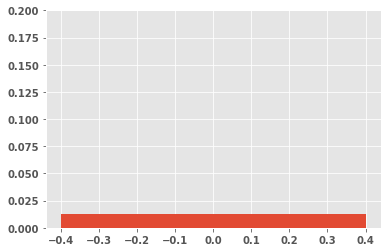

8


<BarContainer object of 8 artists>

(0.0, 0.2)

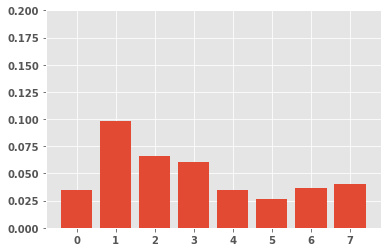

16


<BarContainer object of 16 artists>

(0.0, 0.2)

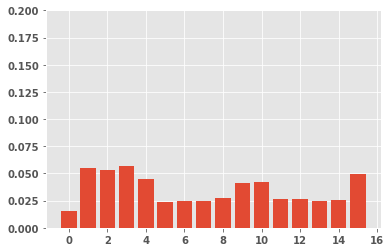

32


<BarContainer object of 32 artists>

(0.0, 0.2)

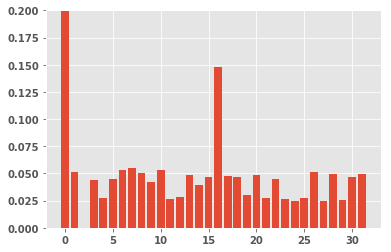

48


<BarContainer object of 48 artists>

(0.0, 0.2)

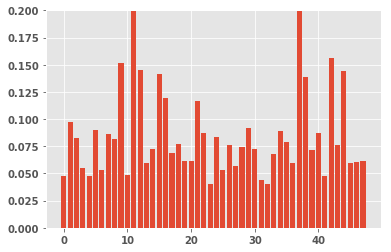

64


<BarContainer object of 64 artists>

(0.0, 0.2)

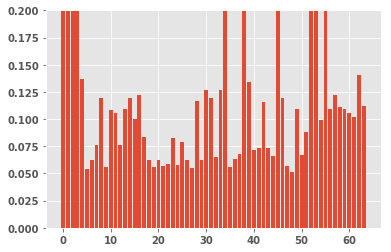

80


<BarContainer object of 80 artists>

(0.0, 0.2)

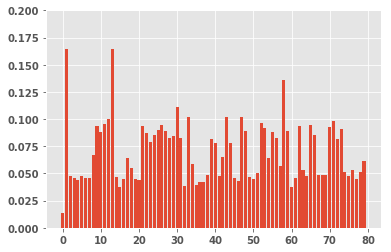

96


<BarContainer object of 96 artists>

(0.0, 0.2)

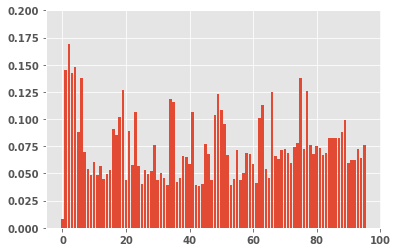

112


<BarContainer object of 112 artists>

(0.0, 0.2)

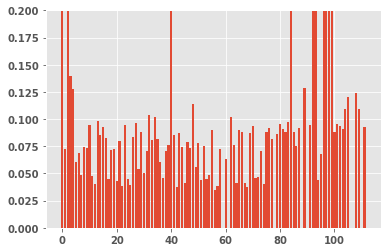

128


<BarContainer object of 128 artists>

(0.0, 0.2)

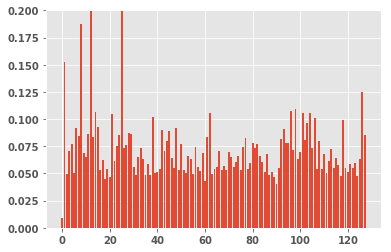

144


<BarContainer object of 144 artists>

(0.0, 0.2)

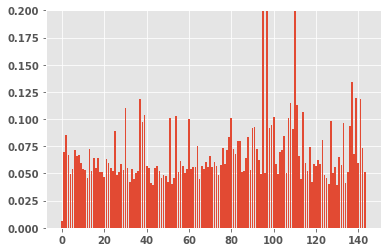

160


<BarContainer object of 160 artists>

(0.0, 0.2)

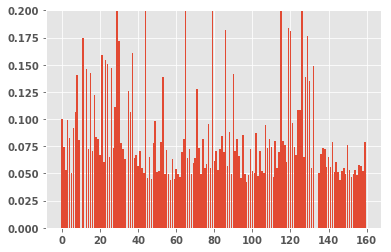

176


<BarContainer object of 176 artists>

(0.0, 0.2)

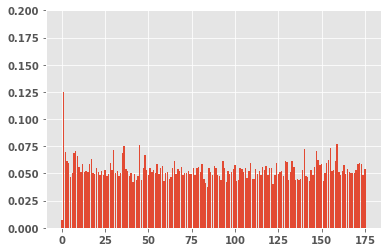

192


<BarContainer object of 192 artists>

(0.0, 0.2)

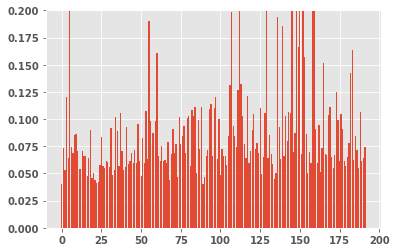

208


<BarContainer object of 208 artists>

(0.0, 0.2)

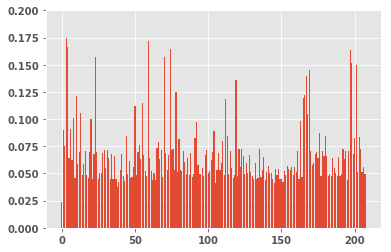

224


<BarContainer object of 224 artists>

(0.0, 0.2)

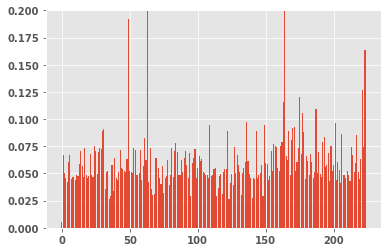

240


<BarContainer object of 240 artists>

(0.0, 0.2)

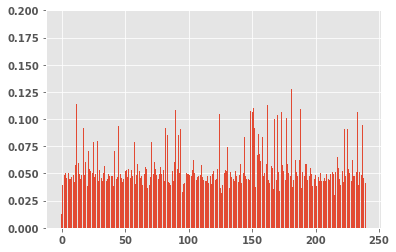

256


<BarContainer object of 256 artists>

(0.0, 0.2)

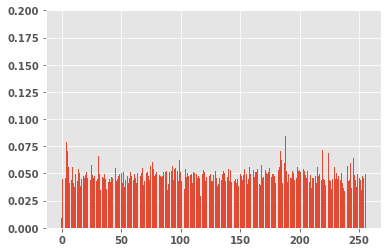

In [56]:
thread_TOT_CYC_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_TOT_CYC')
thread_FETCH_STL_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_FETCH_STALL')

FS_P_CYC_data = {}
for kt in thread_list:
#     print(thread_L1M_data[kt])
#     print(thread_L1A_data[kt])
    FS_P_CYC_data[kt] = thread_FETCH_STL_data[kt] / thread_TOT_CYC_data[kt]
    
for kt in thread_list:
    print kt
    data = list(FS_P_CYC_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=0.2)
    matplotlib.pyplot.show()

### Fetch stall per cyc top ten bad

In [57]:
FSTC_data = select_metric_from_scaling(metric_data, 'DERIVED_RATIO_FETCH_STL_TOT_CYC')
FSTC_dict = {}
for n_thr in thread_list:
    FSTC_dict[n_thr] = filter_libs_out(FSTC_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [58]:
THREAD_COUNT = 1
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(FSTC_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] LayerInfo::is_within_z_sensitive_region(float, float) const",1.94e-01
"[SUMMARY] LayerInfo::is_within_z_sensitive_region(float, float) const",1.94e-01
"[SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::operator()(int, int, int) const",1.46e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 6, 1, 8>::operator()(int, int, int) const",1.46e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<int, 1, 1, 8>::operator()(int, int, int) const",1.41e-01
"[SUMMARY] Matriplex::Matriplex<int, 1, 1, 8>::operator()(int, int, int) const",1.41e-01
"[SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::ConstAt(int, int, int) const",1.40e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 6, 1, 8>::ConstAt(int, int, int) const",1.40e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] computeChi2MPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::MatriplexSym<float, 3, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::Matriplex<float, 1, 1, 8>&, int)",1.35e-01


In [59]:
THREAD_COUNT = 8

get_func_level_metric(FSTC_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] Track::addHitIdx(int, int, float)",2.30e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Track::addHitIdx(int, int, float)",2.30e-01
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Track::errors_nc(),1.94e-01
[SUMMARY] Track::errors_nc(),1.94e-01
"[SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::CopyIn(int, float const*)",1.69e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::MatriplexSym<float, 3, 8>::CopyIn(int, float const*)",1.69e-01
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_atan2f8_l9,1.46e-01
[SUMMARY] __svml_atan2f8_l9,1.46e-01
"[SUMMARY] (anonymous namespace)::SubtractFirst2(Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<float, 2, 1, 8>&)",1.43e-01


In [60]:
THREAD_COUNT = 48
get_func_level_metric(FSTC_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] LayerOfHits::alloc_hits(int),1.08e+00
[SUMMARY] LayerOfHits::alloc_hits(int),1.08e+00
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, float, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)",5.43e-01
"[SUMMARY] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, float, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)",5.43e-01
"[SUMMARY] propagateHelixToRMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int, bool)",5.19e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] propagateHelixToRMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int, bool)",5.19e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] ROOT::Math::MatRepSym<float, 6u>::operator=(ROOT::Math::MatRepSym<float, 6u> const&)",3.33e-01
"[SUMMARY] ROOT::Math::MatRepSym<float, 6u>::operator=(ROOT::Math::MatRepSym<float, 6u> const&)",3.33e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Track::addHitIdx(int, int, float)",3.22e-01


### Fetch Stall count top 10 lists

In [61]:
fetch_stall = select_metric_from_scaling(metric_data, 'PAPI_NATIVE_FETCH_STALL')
fetch_stall_dict = {}
for n_thr in thread_list:
    fetch_stall_dict[n_thr] = filter_libs_out(fetch_stall[n_thr])
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [62]:
THREAD_COUNT = 1
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(fetch_stall_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.68e+08
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.68e+08
[SUMMARY] __svml_sincosf8_l9,8.62e+07
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,8.62e+07
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",7.28e+07
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",7.28e+07
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",5.10e+07
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",5.10e+07
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",4.09e+07


In [63]:
THREAD_COUNT = 8
get_func_level_metric(fetch_stall_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.98e+07
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.98e+07
[SUMMARY] Event::clean_cms_seedtracks(),1.50e+07
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Event::clean_cms_seedtracks(),1.50e+07
[SUMMARY] __svml_sincosf8_l9,1.08e+07
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,1.08e+07
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",9.02e+06
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",9.02e+06
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",6.86e+06


In [64]:
THREAD_COUNT = 48
get_func_level_metric(fetch_stall_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __lll_lock_wait_private,2.62e+07
[SUMMARY] __lll_lock_wait_private,2.62e+07
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Event::clean_cms_seedtracks(),1.43e+07
[SUMMARY] Event::clean_cms_seedtracks(),1.43e+07
[SUMMARY] __read_nocancel,5.67e+06
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __read_nocancel,5.67e+06
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",5.29e+06
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)",5.29e+06
[SUMMARY] __svml_sincosf8_l9,2.89e+06


## Vector Ins per Ins Top 10 counts


<a href='#top'>top</a><br>
<a id='vipi'></a>

In [65]:
vector_ratio = select_metric_from_scaling(metric_data, 'DERIVED_VIPI')
vector_ratio_dict = {}
for n_thr in thread_list:
    vector_ratio_dict[n_thr] = filter_libs_out(vector_ratio[n_thr])
print thread_list

[1, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


In [66]:
THREAD_COUNT = 1
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(vector_ratio_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] _ZN9__gnu_cxx13new_allocatorISt4pairIiiEE9constructIS2_IS2_EEEvPT_DpOT0_,6.93e-01
[SUMMARY] _ZN9__gnu_cxx13new_allocatorISt4pairIiiEE9constructIS2_IS2_EEEvPT_DpOT0_,6.93e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 6, 1, 8>::ConstAt(int, int, int) const",6.91e-01
"[SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::ConstAt(int, int, int) const",6.91e-01
"[SUMMARY] updateParametersMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::MatriplexSym<float, 3, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)",6.31e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] updateParametersMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::MatriplexSym<float, 3, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)",6.31e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] updateParametersEndcapMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::MatriplexSym<float, 3, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)",6.12e-01
"[SUMMARY] updateParametersEndcapMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::MatriplexSym<float, 3, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int)",6.12e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] computeChi2MPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::MatriplexSym<float, 3, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::Matriplex<float, 1, 1, 8>&, int)",5.41e-01


In [67]:
THREAD_COUNT = 8
get_func_level_metric(vector_ratio_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] helixAtRFromIterativeCCS(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",6.11e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] helixAtRFromIterativeCCS(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",6.11e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] LayerInfo::is_within_r_sensitive_region(float, float) const",5.90e-01
"[SUMMARY] LayerInfo::is_within_r_sensitive_region(float, float) const",5.90e-01
"[SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::operator()(int, int, int)",5.79e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 6, 1, 8>::operator()(int, int, int)",5.79e-01
"[SUMMARY] CandCloner::add_cand(int, MkFinder::IdxChi2List const&)",5.46e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] CandCloner::add_cand(int, MkFinder::IdxChi2List const&)",5.46e-01
"[SUMMARY] (anonymous namespace)::MultHelixProp(Matriplex::Matriplex<float, 6, 6, 8> const&, Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&)",4.98e-01


In [68]:
THREAD_COUNT = 48
get_func_level_metric(vector_ratio_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkBuilder::find_tracks_in_layers(CandCloner&, MkFinder*, int, int, int)",7.04e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkBuilder::find_tracks_in_layers(CandCloner&, MkFinder*, int, int, int)",7.04e-01
"[SUMMARY] Matriplex::Matriplex<float, 3, 1, 8>::SlurpIn(char const*, int*, int)",6.53e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 3, 1, 8>::SlurpIn(char const*, int*, int)",6.53e-01
"[SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Matriplex<float, 6, 6, 8> const&, Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&)",4.89e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Matriplex<float, 6, 6, 8> const&, Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&)",4.89e-01
"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::MatriplexSym<float, 3, 8>::SlurpIn(char const*, int*, int)",4.11e-01
"[SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::SlurpIn(char const*, int*, int)",4.11e-01
"[SUMMARY] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int, bool)",4.10e-01


In [80]:
def combine_metrics_2(metric_dict,inc_exc='Inclusive'):
    if inc_exc == 'Inclusive': todrop = 'Exclusive'
    else: todrop = 'Inclusive'
    
    for m in metric_dict:
        if (not m == 'METADATA') and ('DERIVED' not in m):
            metric_dict[m].index = metric_dict[m].index.droplevel()
    
    alldata = metric_dict['PAPI_TOT_CYC'].copy().drop(['Calls','Subcalls',todrop,'ProfileCalls'], axis=1)
    alldata['PAPI_TOT_CYC'] = alldata[inc_exc]
    alldata.drop([inc_exc],axis=1,inplace=True)

    for x in metric_dict.keys():
        if x in ['PAPI_TOT_CYC','METADATA']: continue
        alldata[x] = metric_dict[x][inc_exc]
    return alldata
                
    
data = copy.deepcopy(metric_data)
THREAD_COUNT = 8
metric = 'DERIVED_L1_MISSRATE'

alldata = combine_metrics_2(data[THREAD_COUNT],inc_exc='Exclusive')
selectdata = copy.deepcopy(alldata)

for m in metric_data[THREAD_COUNT].keys():
    if (not m == 'METADATA') and (not m == 'PAPI_TOT_CYC') and (not m == metric): selectdata.drop([m],axis=1,inplace=True)

selectdata.sort_values(by='PAPI_TOT_CYC',ascending=False).head(20)

PAPI_TOT_CYC  \
thread region                                                                                 
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      1.17e+09   
       [SUMMARY] Event::clean_cms_seedtracks()                                     1.17e+09   
5      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      9.04e+08   
       [SUMMARY] syscall                                                           9.04e+08   
       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)               8.65e+08   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      8.65e+08   
4      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      6.76e+08   
       [SUMMARY] syscall                                                           6.76e+08   
       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)               6.36e+08   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      6.36e+08   
6      [SUMMARY] syscall                                                           6.35e+08   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      6.35e+08   
7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)               6.13e+08   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      6.13e+08   
6      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      6.07e+08   
       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)               6.07e+08   
7      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      6.02e+08   
       [SUMMARY] syscall                                                           6.02e+08   
5      [SUMMARY] __svml_sincosf8_l9                                                5.99e+08   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      5.99e+08   

                                                                               DERIVED_L1_MISSRATE  
thread region                                                                                       
0      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             6.48e-03  
       [SUMMARY] Event::clean_cms_seedtracks()                                            6.48e-03  
5      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             1.09e-02  
       [SUMMARY] syscall                                                                  1.09e-02  
       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)                      1.05e-02  
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             1.05e-02  
4      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             1.11e-02  
       [SUMMARY] syscall                                                                  1.11e-02  
       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)                      8.95e-03  
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             8.95e-03  
6      [SUMMARY] syscall                                                                  1.20e-02  
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             1.20e-02  
7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)                      8.11e-03  
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             8.11e-03  
6      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             9.95e-03  
       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)                      9.95e-03  
7      [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...             1.10e-02  
       [SUMMARY] syscall                                             

In [116]:
vipidata = copy.deepcopy(alldata)
metric = 'DERIVED_VIPI'

for m in metric_data[THREAD_COUNT].keys():
    if (not m == 'METADATA') and (not m == 'PAPI_TOT_CYC') and (not m == metric): vipidata.drop([m],axis=1,inplace=True)

def filter_libs_out(dfs):
    dfs_filtered = dfs.groupby(level='region').filter(lambda x: ('.TAU application' not in x.name) and ('tbb' not in x.name) and ('syscall' not in x.name)  and ('std::' not in x.name))
    return dfs_filtered        

vipidata = vipidata.groupby(['region']).mean().sort_values(by='PAPI_TOT_CYC',ascending=False).head(100)
vipidata = filter_libs_out(vipidata)
vipidata = vipidata[vipidata.index.get_level_values('region').str.contains('::')]
# vipidata.sort_values(by=metric,ascending=True).head(20)
vipidata.head(20)

,PAPI_TOT_CYC,DERIVED_VIPI
region,,
[SUMMARY] Event::clean_cms_seedtracks(),1.17e+09,1.47e-01
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",5.21e+08,3.35e-01
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",2.39e+08,3.28e-01
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",1.79e+08,3.30e-01
"[SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",1.42e+08,3.15e-01
"[SUMMARY] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int, bool)",7.84e+07,3.28e-01
"[SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::SlurpIn(char const*, int*, int)",7.68e+07,2.65e-01
"[SUMMARY] void _INTERNALff9a2cb1::helixAtRFromIterativeCCS_impl<Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<int, 1, 1, 8>, Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<float, 1, 1, 8>, Matriplex::Matriplex<float, 6, 6, 8> >(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, int, int, bool)",7.49e+07,3.35e-01
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyOut(int, float*) const",7.23e+07,3.83e-01


In [118]:
br_mr_data = copy.deepcopy(alldata)
metric = 'DERIVED_BRANCH_MR'

for m in metric_data[THREAD_COUNT].keys():
    if (not m == 'METADATA') and (not m == 'PAPI_TOT_CYC') and (not m == metric): br_mr_data.drop([m],axis=1,inplace=True)

def filter_libs_out(dfs):
    dfs_filtered = dfs.groupby(level='region').filter(lambda x: ('.TAU application' not in x.name) and ('tbb' not in x.name) and ('syscall' not in x.name)  and ('std::' not in x.name))
    return dfs_filtered        

br_mr_data = br_mr_data.groupby(['region']).mean().sort_values(by='PAPI_TOT_CYC',ascending=False).head(100)
br_mr_data = filter_libs_out(br_mr_data)
br_mr_data = br_mr_data[br_mr_data.index.get_level_values('region').str.contains('::')]
# vipidata.sort_values(by=metric,ascending=True).head(20)
br_mr_data.head(20)

,PAPI_TOT_CYC,DERIVED_BRANCH_MR
region,,
[SUMMARY] Event::clean_cms_seedtracks(),1.17e+09,6.46e-02
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",5.21e+08,9.65e-02
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",2.39e+08,9.53e-02
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",1.79e+08,8.98e-02
"[SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",1.42e+08,9.58e-02
"[SUMMARY] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 3, 1, 8> const&, Matriplex::MatriplexSym<float, 6, 8>&, Matriplex::Matriplex<float, 6, 1, 8>&, int, bool)",7.84e+07,1.03e-01
"[SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::SlurpIn(char const*, int*, int)",7.68e+07,8.61e-02
"[SUMMARY] void _INTERNALff9a2cb1::helixAtRFromIterativeCCS_impl<Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<int, 1, 1, 8>, Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<float, 1, 1, 8>, Matriplex::Matriplex<float, 6, 6, 8> >(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, int, int, bool)",7.49e+07,9.38e-02
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyOut(int, float*) const",7.23e+07,1.00e-01


In [90]:
# t,d = scaling_plot(metric_data, inclusive=True, plot=True, function="MultHelixPropTransp", metric='DERIVED_L1_MISSRATE', max=False)
# print d[8]
# t,d = scaling_plot(metric_data, inclusive=True, plot=True, function="MultHelixPropTransp", metric='DERIVED_L1_MISSRATE', max=True)
# print d[8]

###  Resource Stalls vs thread count
Similar to above these cells show the Resource Stalls. In this case we have nothing to compute, so we simply call the function. Future work includes exploring the different types of stalls.

In [ ]:
thread_list, res_stall_data = scaling_plot(metric_data, metric='PAPI_RES_STL')

In [ ]:
thread_stall_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_RES_STL')
thread_bar_plots(thread_stall_data, thread_list, 4000000000)

## Correlations

In [125]:
cm = sns.light_palette("yellow", as_cmap=True)

corr_data = copy.deepcopy(alldata)
corr_data = corr_data[corr_data.index.get_level_values('region').str.contains('FindCandidatesClone')]
# corr_data.head(10)
correlations_pearson = alldata.corr('pearson').fillna(0)    # Other methods: 'kendall', 'spearman'
correlations_pearson.style.format("{:.2%}").background_gradient(cmap=cm)

,PAPI_TOT_CYC,DERIVED_VIPI,PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,PAPI_L2_TCA,PAPI_NATIVE_LLC_MISSES,PAPI_TLB_DM,PAPI_L2_TCM,PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,PAPI_NATIVE_FETCH_STALL,PAPI_L1_TCM,PAPI_BR_MSP,PAPI_RES_STL,PAPI_TOT_INS,DERIVED_IPC,PAPI_BR_CN,DERIVED_RATIO_FETCH_STL_TOT_CYC,DERIVED_L1_MISSRATE,DERIVED_L3_MISSRATE,PAPI_BR_UCN,PAPI_NATIVE_LLC_REFERENCES,PAPI_BR_INS,DERIVED_L2_MISSRATE,DERIVED_BRANCH_MR,DERIVED_CPI,PAPI_LST_INS,PAPI_NATIVE_RS_FULL_STALL
PAPI_TOT_CYC,100.00%,-9.52%,61.28%,87.37%,81.57%,84.38%,81.22%,82.57%,73.79%,87.38%,82.90%,58.53%,91.26%,-5.68%,75.89%,-4.50%,2.10%,1.61%,67.36%,86.89%,77.81%,4.67%,-4.50%,10.39%,91.68%,59.29%
DERIVED_VIPI,-9.52%,100.00%,-11.11%,-14.39%,-16.41%,-14.95%,-17.95%,6.85%,-4.71%,-16.35%,-16.63%,-28.91%,-14.85%,4.62%,-16.48%,21.44%,-15.90%,8.41%,-25.49%,-15.59%,-17.86%,2.63%,21.44%,33.97%,-9.94%,-28.42%
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,61.28%,-11.11%,100.00%,58.15%,33.03%,36.80%,33.07%,46.21%,40.56%,48.81%,80.94%,28.39%,69.91%,-2.94%,90.08%,-9.28%,-7.88%,-11.91%,28.97%,58.44%,84.68%,-11.17%,-9.28%,-3.07%,66.49%,28.77%
PAPI_L2_TCA,87.37%,-14.39%,58.15%,100.00%,90.57%,93.22%,90.50%,84.51%,79.00%,92.77%,80.78%,64.08%,94.34%,-3.23%,73.80%,-9.97%,1.13%,-0.03%,72.40%,99.31%,77.17%,0.23%,-9.97%,-6.34%,95.78%,64.81%
PAPI_NATIVE_LLC_MISSES,81.57%,-16.41%,33.03%,90.57%,100.00%,96.20%,99.37%,75.38%,74.83%,96.98%,74.46%,82.03%,86.33%,-4.80%,60.81%,-3.91%,16.11%,17.89%,89.38%,89.56%,68.58%,19.49%,-3.91%,-8.51%,86.78%,82.62%
PAPI_TLB_DM,84.38%,-14.95%,36.80%,93.22%,96.20%,100.00%,96.50%,79.05%,76.57%,95.11%,73.71%,74.12%,87.82%,-3.80%,61.56%,-8.26%,11.86%,10.41%,83.28%,92.69%,67.93%,15.69%,-8.26%,-4.81%,89.19%,75.05%
PAPI_L2_TCM,81.22%,-17.95%,33.07%,90.50%,99.37%,96.50%,100.00%,75.39%,73.58%,97.35%,75.11%,82.10%,86.74%,-3.44%,61.56%,-4.24%,17.44%,18.52%,90.17%,89.40%,69.18%,21.69%,-4.24%,-7.16%,87.12%,82.72%
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,82.57%,6.85%,46.21%,84.51%,75.38%,79.05%,75.39%,100.00%,71.82%,80.01%,68.43%,32.14%,87.78%,-2.83%,61.20%,-4.83%,-8.28%,-2.46%,47.92%,82.75%,61.47%,-1.78%,-4.83%,-6.57%,90.70%,33.14%
PAPI_NATIVE_FETCH_STALL,73.79%,-4.71%,40.56%,79.00%,74.83%,76.57%,73.58%,71.82%,100.00%,73.79%,52.00%,51.19%,72.01%,-2.63%,43.16%,-3.33%,-1.03%,-1.20%,46.41%,77.68%,45.11%,0.24%,-3.33%,-1.91%,74.59%,52.54%
PAPI_L1_TCM,87.38%,-16.35%,48.81%,92.77%,96.98%,95.11%,97.35%,80.01%,73.79%,100.00%,85.88%,79.17%,93.86%,-3.86%,74.83%,-5.46%,16.62%,14.65%,88.23%,91.63%,80.68%,21.11%,-5.46%,-6.56%,93.41%,79.76%
